In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # unused import, required by projection='3d'
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set()

### Neural network class

In [2]:
class Model(nn.Module):
    """Basic customizable network structure
    """
    def __init__(self,
                 input_size=1,
                 output_size=1,
                 hidden_size=2,
                 n_layers=1,
                 activation='relu',
                ):
        super(Model, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        # number of hidden layers
        self.n_layers = n_layers
        
        size  = [self.input_size] + [hidden_size,] * (self.n_layers)
        self.layers = [nn.Linear(size[i-1], size[i]) for i in range(1, self.n_layers+1)]
        self.layers.append(nn.Linear(hidden_size, self.output_size))
        
        self.layers = nn.ModuleList(self.layers)
        
        if activation.lower() == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        elif activation.lower() == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise Exception('{} not an available activation'.format(activation))
        
    def forward(self, x):
        for i in range(self.n_layers):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [3]:
class TrainManager():
    """Helper class to centralize various parameters/optimizer/criterion choices, 
    train and test routines.
    """
    def __init__(self,
                 model,
                 dataset=[],
                 tol=0.1,
                 tol_type='absolute',
                 num_epochs_max=int(1e3),
                 batch_size=10,
                 lr=0.01,
                 criterion=nn.MSELoss(),
                 optimizer_name='SGD',
                 verbose=False,
                ):
        
        self._model = model
        self.dataset = dataset
        self.tol = tol
        self.tol_type = tol_type
        self.num_epochs_max = num_epochs_max
        self.batch_size = batch_size
        self.lr = lr
        self.criterion = criterion
        self.optimizer_name = optimizer_name
        self.verbose = verbose
        self.num_epochs = 0
        self.train_error = torch.tensor([0.0])
        self.test_error = torch.tensor([0.0])
        
    @property
    def model(self):
        return self._model
    @model.setter
    def model(self, new_model):
        """Load new model and relink the optimizer to 
        the parameters of the current model.
        """
        self._model = new_model
        self.optimizer_name = self._optimizer_name
        
    @property
    def optimizer_name(self):
        return self._optimizer_name
    @optimizer_name.setter
    def optimizer_name(self, new_optimizer_name):
        """Set optimizer from optimizer_name and
        most importantly, link it to the parameters 
        of the current model loaded in the train manager.
        """
        self._optimizer_name = new_optimizer_name
        if new_optimizer_name.lower() == 'sgd':
            self.optimizer = torch.optim.SGD(self._model.parameters(), lr=self.lr)
        elif new_optimizer_name.lower() == 'adam':
            self.optimizer = torch.optim.Adam(self._model.parameters(), lr=self.lr)
        elif new_optimizer_name.lower() == 'rmsprop':
            self.optimizer = torch.optim.RMSprop(self._model.parameters(), lr=self.lr)
        else:
            raise Exception('Unknown optimizer {}'.format(optimizer))
            
    def train(self):
        """Train model and display learning_curve.
        """
        train_error = []
        train_loader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model.train()
        keep_training = True
        epoch = 0
        while keep_training:
            epoch += 1
            epoch_average_loss = 0.0
            for (X_batch, y_real) in train_loader:
                y_pre = self.model.forward(X_batch).view(-1)
                loss = self.criterion(y_pre, y_real)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_average_loss += loss.item() * self.batch_size / len(self.dataset)
            # stop training after loss tolerance is reached
            if epoch != 1:
                if self.tol_type == 'increment' and np.abs(train_error[-1]-epoch_average_loss) < self.tol\
                or self.tol_type == 'absolute' and epoch_average_loss < self.tol\
                or epoch >= self.num_epochs_max:
                    keep_training = False
                
            train_error.append(epoch_average_loss)
            if self.verbose:
                print('Epoch {}, Loss: {:.4f}'.format(epoch, epoch_average_loss))
            
        if self.verbose:
            # plot the training error wrt. the number of epochs: 
            plt.plot(train_error)
            plt.xlabel("num_epochs")
            plt.ylabel("Train error")
            plt.title("Visualization of convergence")
        self.num_epochs = epoch
        self.train_error = train_error
    
    def test(self, X_val, y_real):
        """Evaluate model on X_val.
        """
        # predict labels for validation set
        self.model.eval() # set the model to test mode
        with torch.no_grad():
            y_pre = self.model.forward(X_val).view(-1)
        
        self.test_error = self.criterion(y_pre, y_real).item()

### Generate data : sinusoid mountains

In [4]:
N = int(1e4)
noise_std = 0.1

def f(x1, x2):
    return np.sin(2*np.pi/5*x1)*np.sin(3*np.pi/5*x2)

x1 = 2*(2*np.random.rand(N)-1)
x2 = 3*(2*np.random.rand(N)-1)
X = np.stack([x1, x2], axis=1)
y = f(x1, x2) + noise_std*np.random.randn(N)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
training_set = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test)

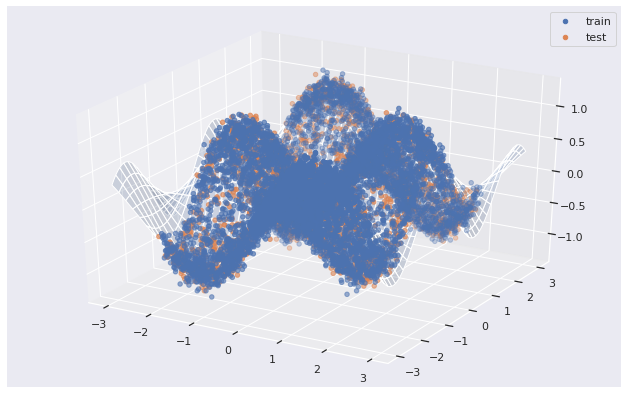

In [5]:
fig = plt.figure(figsize=(11, 7))

x1_plot = x2_plot = np.arange(-3.0, 3.0, 0.05)
X1_plot, X2_plot = np.meshgrid(x1_plot, x2_plot)
y_plot = np.array(f(np.ravel(X1_plot), np.ravel(X2_plot)))
Y_plot = y_plot.reshape(X1_plot.shape)

ax = fig.gca(projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, label='train')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, label='test')
ax.plot_surface(X1_plot, X2_plot, Y_plot, alpha=0.2)
ax.legend()
plt.show()

### Training

In [6]:
# Fully connectected, fully trainable model
model = Model(input_size=2,
              output_size=1,
              hidden_size=32,
              n_layers=3,
             )

# Non-trainable layer
model_random = Model(input_size=2,
                     output_size=32,
                     hidden_size=32,
                     n_layers=2,
                    )

# Trainable layer on top of the previous random, non-trainable network
model_lazy = Model(input_size=32,
                   output_size=1,
                   hidden_size=32,
                   n_layers=0,
                  )

# choose the hyperparameters for training
num_epochs = 50
batch_size = 250

# training criterion. 
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_lazy = torch.optim.Adam(model_lazy.parameters(), lr=0.01)

In [7]:
train_error = []
train_loader = DataLoader(training_set, batch_size, shuffle=True)
postfix = {
    'loss': np.inf,
    'test error': np.inf,
}
        
with tqdm(total=num_epochs, postfix=postfix) as pbar:
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        model.train()
        for (X_batch, y_real) in train_loader:
            y_pre = model.forward(X_batch).view(-1)
            loss = criterion(y_pre, y_real)

            # train fully connected
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_average_loss += loss.item() * batch_size / len(training_set)
        train_error.append(epoch_average_loss)
        
        model.eval()
        with torch.no_grad():
            y_pre = model.forward(X_test).view(-1)
        
        test_error = criterion(y_pre, y_test).item()
        
        # log
        postfix['loss'] = epoch_average_loss
        postfix['test error'] = test_error
        pbar.set_postfix(postfix)
        pbar.update()

100%|██████████| 50/50 [00:12<00:00,  4.08it/s, loss=0.0119, test error=0.0123]


In [8]:
train_error_lazy = []
train_loader = DataLoader(training_set, batch_size, shuffle=True)
postfix = {
    'loss (lazy)': np.inf,
    'test error (lazy)': np.inf,
}
        
with tqdm(total=num_epochs, postfix=postfix) as pbar:
    for epoch in range(num_epochs):
        epoch_average_loss_lazy = 0.0
        model_lazy.train()
        for (X_batch, y_real) in train_loader:
            y_pre_lazy = model_lazy.forward(model_random(X_batch)).view(-1)
            loss_lazy = criterion(y_pre_lazy, y_real)

            # train lazy one-layer
            optimizer_lazy.zero_grad()
            loss_lazy.backward()
            optimizer_lazy.step()
            
            epoch_average_loss_lazy += loss_lazy.item() * batch_size / len(training_set)
        train_error_lazy.append(epoch_average_loss_lazy)
        
        model_lazy.eval()
        with torch.no_grad():
            y_pre_lazy = model_lazy.forward(model_random(X_test)).view(-1)
        
        test_error_lazy = criterion(y_pre_lazy, y_test).item()
        
        # log
        postfix['loss (lazy)'] = epoch_average_loss_lazy
        postfix['test error (lazy)'] = test_error_lazy
        pbar.set_postfix(postfix)
        pbar.update()

100%|██████████| 50/50 [00:10<00:00,  4.90it/s, loss (lazy)=0.185, test error (lazy)=0.179]


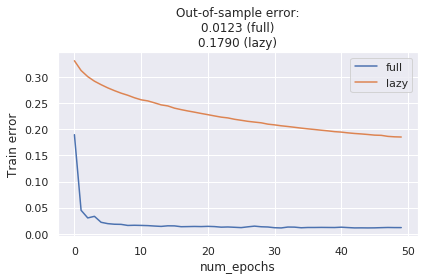

In [9]:
plt.plot(train_error, label='full')
plt.plot(train_error_lazy, label='lazy')
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Out-of-sample error:\n{:.4f} (full)\n{:.4f} (lazy)".format(test_error, test_error_lazy))
plt.legend()
plt.tight_layout()
plt.show()

### Generate data : sinusoid mountains in higher dimensions

In [10]:
N = int(1e4)
d = 64
noise_std = 0.1

def f(x):
    d = x.shape[1]
    freqs = np.random.randint(1, 100, d)
    return np.prod(np.sin(freqs*np.pi/50*x))

X = (2*np.random.rand(N, d)-1)
y = f(X) + noise_std*np.random.randn(N)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
training_set = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test)

In [11]:
# Fully connectected, fully trainable model
model = Model(input_size=d,
              output_size=1,
              hidden_size=32,
              n_layers=3,
             )

# Non-trainable layer
model_random = Model(input_size=d,
                     output_size=32,
                     hidden_size=32,
                     n_layers=2,
                    )

# Trainable layer on top of the previous random, non-trainable network
model_lazy = Model(input_size=32,
                   output_size=1,
                   hidden_size=32,
                   n_layers=0,
                  )

# choose the hyperparameters for training
num_epochs = 50
batch_size = 250

# training criterion. 
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_lazy = torch.optim.Adam(model_lazy.parameters(), lr=0.01)

### Training

In [12]:
train_error = []
train_loader = DataLoader(training_set, batch_size, shuffle=True)
postfix = {
    'loss': np.inf,
    'test error': np.inf,
}
        
with tqdm(total=num_epochs, postfix=postfix) as pbar:
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        model.train()
        for (X_batch, y_real) in train_loader:
            y_pre = model.forward(X_batch).view(-1)
            loss = criterion(y_pre, y_real)

            # train fully connected
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_average_loss += loss.item() * batch_size / len(training_set)
        train_error.append(epoch_average_loss)
        
        model.eval()
        with torch.no_grad():
            y_pre = model.forward(X_test).view(-1)
        
        test_error = criterion(y_pre, y_test).item()
        
        # log
        postfix['loss'] = epoch_average_loss
        postfix['test error'] = test_error
        pbar.set_postfix(postfix)
        pbar.update()

100%|██████████| 50/50 [00:10<00:00,  4.90it/s, loss=0.00307, test error=0.0174]


In [13]:
train_error_lazy = []
train_loader = DataLoader(training_set, batch_size, shuffle=True)
postfix = {
    'loss (lazy)': np.inf,
    'test error (lazy)': np.inf,
}
        
with tqdm(total=num_epochs, postfix=postfix) as pbar:
    for epoch in range(num_epochs):
        epoch_average_loss_lazy = 0.0
        model_lazy.train()
        for (X_batch, y_real) in train_loader:
            y_pre_lazy = model_lazy.forward(model_random(X_batch)).view(-1)
            loss_lazy = criterion(y_pre_lazy, y_real)

            # train lazy one-layer
            optimizer_lazy.zero_grad()
            loss_lazy.backward()
            optimizer_lazy.step()
            
            epoch_average_loss_lazy += loss_lazy.item() * batch_size / len(training_set)
        train_error_lazy.append(epoch_average_loss_lazy)
        
        model_lazy.eval()
        with torch.no_grad():
            y_pre_lazy = model_lazy.forward(model_random(X_test)).view(-1)
        
        test_error_lazy = criterion(y_pre_lazy, y_test).item()
        
        # log
        postfix['loss (lazy)'] = epoch_average_loss_lazy
        postfix['test error (lazy)'] = test_error_lazy
        pbar.set_postfix(postfix)
        pbar.update()

100%|██████████| 50/50 [00:09<00:00,  5.21it/s, loss (lazy)=0.00972, test error (lazy)=0.00981]


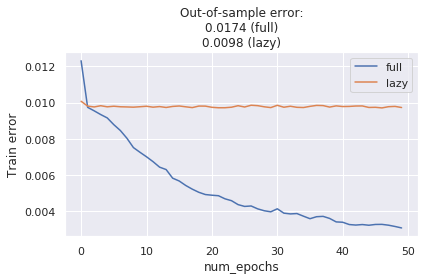

In [14]:
plt.plot(train_error, label='full')
plt.plot(train_error_lazy, label='lazy')
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Out-of-sample error:\n{:.4f} (full)\n{:.4f} (lazy)".format(test_error, test_error_lazy))
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion
Not only is lazy training faster, but in high dimension it generalizes better than a fully trained network.
Lazy training (only training a subset of neurons or layers and considering the rest as randomly generated features) is a form a regularization.